In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
def randomized_local_search(
    objective_function,
    starting_point,
    max_iterations=100,
    step_size=0.5,
    probability=0.2,
    bounds=None,
    verbose=False,
    log_path=False
):
    """
    Універсальний алгоритм випадкового локального пошуку з логуванням.

    Параметри:
        objective_function: функція, яку потрібно мінімізувати (f(x) -> float)
        starting_point: початкова точка (list/tuple/np.array)
        max_iterations: кількість ітерацій
        step_size: максимальний розмір кроку
        probability: імовірність прийняти гірше рішення
        bounds: межі [(min1, max1), (min2, max2), ...] або None
        verbose: якщо True — показує прогрес у консолі
        log_path: якщо True — повертає історію пошуку

    Повертає:
        best_point, best_value, history (якщо log_path=True)
    """
    current_point = np.array(starting_point, dtype=float)
    current_value = objective_function(current_point)

    # лог для траєкторії
    history = [(current_point.copy(), current_value)]

    for i in range(max_iterations):
        # випадковий сусід
        new_point = current_point + np.random.uniform(-step_size, step_size, size=len(current_point))

        # обмеження межами
        if bounds is not None:
            for j, (low, high) in enumerate(bounds):
                new_point[j] = np.clip(new_point[j], low, high)

        new_value = objective_function(new_point)

        # прийняття рішення
        if new_value < current_value or random.random() < probability:
            current_point, current_value = new_point, new_value

        # логування
        history.append((current_point.copy(), current_value))

        if verbose and i % 10 == 0:
            print(f"Ітерація {i:4d} | Поточне значення: {current_value:.6f}")

    if log_path:
        return current_point, current_value, history
    else:
        return current_point, current_value


In [3]:
def business_loss(x,
    base_rev_per_user=15.0,
    alpha=12.0,   # сила миттєвого ефекту бонусу
    beta=1.2,     # швидкість насичення миттєвого ефекту
    gamma=4.0,    # коефіцієнт майбутньої вартості (LTV) за бонус
    c1=1.5,       # лінійні витрати на бонус
    c2=0.3):      # квадратичні витрати (ріст витрат при великих бонусах)
    """
    x: [bonus, activity]
    Повертає scalar loss (менше — краще).
    Параметри дають контроль над формою кривої.
    """
    bonus, activity = x
    bonus = float(bonus)
    activity = float(activity)

    # 1) Базовий дохід від активності (без бонусу)
    base_revenue = base_rev_per_user * activity

    # 2) Миттєвий ефект бонусу: має вигляд  alpha * (1 - exp(-beta * bonus)) * activity
    #    — швидкий підйом при малих bonus, насичення при великих
    immediate_revenue = alpha * (1 - np.exp(-beta * bonus)) * activity

    # 3) Майбутній ефект (LTV/утримання): припустимо, лінійна вигода від невеликого bonus
    future_revenue = gamma * bonus * activity

    total_revenue = base_revenue + immediate_revenue + future_revenue

    # 4) Витрати: лінійні + квадратичні частини
    cost = c1 * bonus + c2 * bonus**2

    # 5) Втрати від неактивності (підкреслює важливість activity)
    inactivity_loss = (1 - activity)**2 * 8.0

    # Підсумок: втрати = витрати + неефективність - дохід
    loss = cost + inactivity_loss - total_revenue
    return loss

In [4]:
best_point, best_value, history = randomized_local_search(
    objective_function=business_loss,
    starting_point=[0, 0],
    max_iterations=200,
    step_size=0.4,
    probability=0.1,
    # bounds=[(-10, 10), (-10, 10)],
    verbose=True,
    log_path=True
)

Ітерація    0 | Поточне значення: 0.934521
Ітерація   10 | Поточне значення: 2.979630
Ітерація   20 | Поточне значення: -17.252064
Ітерація   30 | Поточне значення: -26.927050
Ітерація   40 | Поточне значення: -44.399176
Ітерація   50 | Поточне значення: -55.296672
Ітерація   60 | Поточне значення: -76.850122
Ітерація   70 | Поточне значення: -84.917329
Ітерація   80 | Поточне значення: -93.272326
Ітерація   90 | Поточне значення: -101.935610
Ітерація  100 | Поточне значення: -105.949974
Ітерація  110 | Поточне значення: -122.238043
Ітерація  120 | Поточне значення: -124.928352
Ітерація  130 | Поточне значення: -131.706240
Ітерація  140 | Поточне значення: -131.674423
Ітерація  150 | Поточне значення: -151.141448
Ітерація  160 | Поточне значення: -159.676858
Ітерація  170 | Поточне значення: -171.335432
Ітерація  180 | Поточне значення: -184.747719
Ітерація  190 | Поточне значення: -187.921642


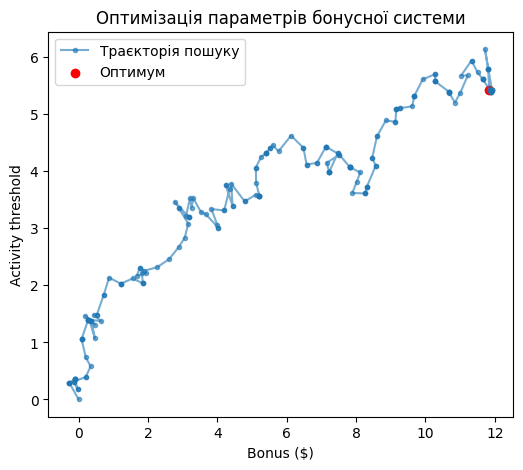

In [5]:
xs, ys, zs = zip(*[(p[0], p[1], v) for p, v in history])
plt.figure(figsize=(6, 5))
plt.plot(xs, ys, marker='.', alpha=0.6, label="Траєкторія пошуку")
plt.scatter(best_point[0], best_point[1], color='red', label='Оптимум')
plt.title("Оптимізація параметрів бонусної системи")
plt.xlabel("Bonus ($)")
plt.ylabel("Activity threshold")
plt.legend()
plt.show()

In [6]:
import random
import math

In [7]:
def sphere_function(x):
    return sum(xi ** 2 for xi in x)

In [8]:
# Random Local Search
def random_local_search(func, bounds, iterations=1000, epsilon=1e-6):
    dim = len(bounds)
    best = [random.uniform(b[0], b[1]) for b in bounds]
    best_value = func(best)

    for _ in range(iterations):
        candidate = [random.uniform(b[0], b[1]) for b in bounds]
        candidate_value = func(candidate)

        # Умова зупинки
        if abs(best_value - candidate_value) < epsilon:
            break

        if candidate_value < best_value:
            best, best_value = candidate, candidate_value

    return best, best_value

In [9]:
# Simulated Annealing
def simulated_annealing(func, bounds, iterations=1000, initial_temp=1000, cooling_rate=0.99, epsilon=1e-6):
    dim = len(bounds)
    current = [random.uniform(b[0], b[1]) for b in bounds]
    current_value = func(current)
    best, best_value = current, current_value
    temp = initial_temp

    for t in range(iterations):
        # Охолодження
        if temp <= epsilon:  # Якщо температура надто низька, завершуємо
            break

        # Генерація сусіда
        neighbor = [current[i] + random.uniform(-temp, temp) for i in range(dim)]
        neighbor = [max(min(neighbor[i], bounds[i][1]), bounds[i][0]) for i in range(dim)]
        neighbor_value = func(neighbor)

        # Прийняття сусіда
        if neighbor_value < current_value or math.exp((current_value - neighbor_value) / temp) > random.random():
            current, current_value = neighbor, neighbor_value

        # Оновлення найкращого розв'язку
        if current_value < best_value:
            best, best_value = current, current_value

        temp = initial_temp / (1 + cooling_rate * t)

    return best, best_value

In [10]:
# Межі для функції
bounds = [(-5, 5), (-5, 5)]

print("\nRandom Local Search:")
rls_solution, rls_value = random_local_search(sphere_function, bounds)
print("Розв'язок:", rls_solution, "Значення:", rls_value)

print("\nSimulated Annealing:")
sa_solution, sa_value = simulated_annealing(sphere_function, bounds)
print("Розв'язок:", sa_solution, "Значення:", sa_value)


Random Local Search:
Розв'язок: [-0.07015422686714956, 0.09665159378810273] Значення: 0.014263146129107908

Simulated Annealing:
Розв'язок: [0.014063830040282999, -0.009215338084600289] Значення: 0.000282713771415451
